In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
import os
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import shap

from lib.lib import Import_data

path = Import_data()
# get all files in the directory
files = os.listdir(path)
print(files)

Path to dataset files: C:\Users\kskdu\.cache\kagglehub\datasets\arashnic\earthquake-magnitude-damage-and-impact\versions\6
['csv_building_damage_assessment.csv', 'csv_building_ownership_and_use.csv', 'csv_building_structure.csv', 'csv_household_demographics.csv', 'csv_household_earthquake_impact.csv', 'csv_household_resources.csv', 'csv_individual_demographics.csv', 'mapping.csv', 'ward_vdcmun_district_name_mapping.csv']


In [91]:
building_structure = pd.read_csv(path + "/csv_building_structure.csv")
dmg_assesment = pd.read_csv(path + "/csv_building_damage_assessment.csv")

building_structure.keys()

C:\Users\kskdu\AppData\Local\Temp\ipykernel_9072\4115963309.py:2: DtypeWarning: Columns (5,17,29,34,35,36,37,38,39,40,41,42,43,47,50) have mixed types. Specify dtype option on import or set low_memory=False.


Index(['building_id', 'district_id', 'vdcmun_id', 'ward_id',
       'count_floors_pre_eq', 'count_floors_post_eq', 'age_building',
       'plinth_area_sq_ft', 'height_ft_pre_eq', 'height_ft_post_eq',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'condition_post_eq', 'damage_grade', 'technical_solution_proposed'],
      dtype='object')

In [92]:
# Filter out uneeded rows
dmg_assesment = dmg_assesment.drop(columns=[col for col in dmg_assesment.columns if 'has_geotechnical_risk_' not in col and col != 'building_id'])

In [93]:
dmg_assesment.keys()

Index(['building_id', 'has_geotechnical_risk_land_settlement',
       'has_geotechnical_risk_fault_crack',
       'has_geotechnical_risk_liquefaction', 'has_geotechnical_risk_landslide',
       'has_geotechnical_risk_rock_fall', 'has_geotechnical_risk_flood',
       'has_geotechnical_risk_other'],
      dtype='object')

In [94]:
building_structure.keys()

Index(['building_id', 'district_id', 'vdcmun_id', 'ward_id',
       'count_floors_pre_eq', 'count_floors_post_eq', 'age_building',
       'plinth_area_sq_ft', 'height_ft_pre_eq', 'height_ft_post_eq',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'condition_post_eq', 'damage_grade', 'technical_solution_proposed'],
      dtype='object')

In [95]:
# Merge dmg assesment into building structure on building id column
building_structure = building_structure.merge(dmg_assesment, on='building_id')
building_structure.keys()

Index(['building_id', 'district_id', 'vdcmun_id', 'ward_id',
       'count_floors_pre_eq', 'count_floors_post_eq', 'age_building',
       'plinth_area_sq_ft', 'height_ft_pre_eq', 'height_ft_post_eq',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'condition_post_eq', 'damage_grade', 'technical_solution_proposed',
       'has_geotechnical_risk_land_settlement',
       'has_geotechnical_risk_fault_crack',
       'has_geotechnical_risk_liquefaction', 'ha

In [96]:
len(building_structure)

762106

In [97]:
# Remove id columns, columns containing post_eq and technical_solution_proposed and position
building_structure = building_structure.drop(columns=[col for col in building_structure.columns if 'id' in col or 'post_eq' in col or 'technical_solution_proposed' in col in col])

In [98]:
len(building_structure)

762106

In [99]:
# Dropping floors above 6
building_structure = building_structure[building_structure["count_floors_pre_eq"] < 6]

In [100]:
len(building_structure)

761661

In [101]:
# Dropping rows with plinith area above 1500
building_structure = building_structure[building_structure["plinth_area_sq_ft"] <= 1500]

In [102]:
# Changing damage categories into numerical values
building_structure["damage_grade"] = building_structure["damage_grade"].replace({"Grade 1": 0, "Grade 2": 1, "Grade 3": 2, "Grade 4": 3, "Grade 5": 4})

C:\Users\kskdu\AppData\Local\Temp\ipykernel_9072\555852273.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [103]:
building_structure.keys()

Index(['count_floors_pre_eq', 'age_building', 'plinth_area_sq_ft',
       'height_ft_pre_eq', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'damage_grade', 'has_geotechnical_risk_land_settlement',
       'has_geotechnical_risk_fault_crack',
       'has_geotechnical_risk_liquefaction', 'has_geotechnical_risk_rock_fall',
       'has_geotechnical_risk_flood', 'has_geotechnical_risk_other'],
      dtype='object')

In [104]:
# Translating category columns to category type for native category support
categorical_columns = [
    "land_surface_condition", 
    "foundation_type", 
    "roof_type", 
    "ground_floor_type",
    "other_floor_type",
    "plan_configuration",
]

for col in categorical_columns:
    building_structure[col] = building_structure[col].astype('category')

In [105]:
print(building_structure.isna().sum())
building_structure = building_structure.dropna()

count_floors_pre_eq                        0
age_building                               0
plinth_area_sq_ft                          0
height_ft_pre_eq                           0
land_surface_condition                     0
foundation_type                            0
roof_type                                  0
ground_floor_type                          0
other_floor_type                           0
position                                   1
plan_configuration                         1
has_superstructure_adobe_mud               0
has_superstructure_mud_mortar_stone        0
has_superstructure_stone_flag              0
has_superstructure_cement_mortar_stone     0
has_superstructure_mud_mortar_brick        0
has_superstructure_cement_mortar_brick     0
has_superstructure_timber                  0
has_superstructure_bamboo                  0
has_superstructure_rc_non_engineered       0
has_superstructure_rc_engineered           0
has_superstructure_other                   0
damage_gra

In [106]:
from imblearn.over_sampling import SMOTE
from collections import Counter

def train(X_train, y_train, X_val, y_val,params, rounds):
    # Create the LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # Train the model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=rounds,
        valid_sets=[train_data, val_data],
    )

    return model

In [107]:
def test_classification(model, X_test, y_test, keys):
    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_class)
    report = classification_report(y_test, y_pred_class)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)

    # Feature importance
    importance = model.feature_importance(importance_type='split')
    feature_names = keys
    feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

    print("Feature Importance (top 10):")
    for feature, importance in feature_importance[:10]:
        print(f"{feature}: {importance}")

    return accuracy, feature_importance

In [108]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def test_regression(model, X, y_true):
    y_pred = model.predict(X)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

In [121]:
categorical_columns = [
    # 'land_surface_condition', 
    'foundation_type', 
    'roof_type', 
    'ground_floor_type', 
    'other_floor_type', 
    'position'
    #'plan_configuration'
]

building_structure["height_plinth_ratio"] = building_structure["height_ft_pre_eq"] / building_structure["plinth_area_sq_ft"]
building_structure = building_structure[building_structure["height_plinth_ratio"] < 0.3]

# I want to combine these: 'roof_type_Bamboo/Timber-Heavy roof', 'roof_type_Bamboo/Timber-Light roof'
# They are both in the roof type column. Create a new category thats called Bamboo/Timber
building_structure["roof_type"] = building_structure["roof_type"].replace({"Bamboo/Timber-Heavy roof": "Bamboo/Timber", "Bamboo/Timber-Light roof": "Bamboo/Timber"})

to_drop = [
    "damage_grade",
    "plinth_area_sq_ft",
    "height_ft_pre_eq",
    "plan_configuration",
    "land_surface_condition",
    #"position",
    #"count_floors_pre_eq",
]

# Use pandas get_dummies function to one-hot encode
X = pd.get_dummies(
    building_structure.drop(columns=to_drop), 
    columns=categorical_columns,
    drop_first=False,  # Set to True if you want to avoid multicollinearity
    prefix=categorical_columns,
    prefix_sep='_'
)

keys = X.keys()
X = X.to_numpy()

In [122]:
y = building_structure["damage_grade"].astype("Int64").to_numpy()
# y 0 is 0, 1 is 1, 2 is 1, 3 is 1, 4 is 2
y = np.where(y == 0, 0, np.where(y == 1, 1, np.where(y == 2, 1, np.where(y == 3, 1, 2))))

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Original training distribution:", Counter(y_train))
#smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)
print("Sampled training distribution:", Counter(y_train))

Original training distribution: Counter({np.int64(1): 283765, np.int64(2): 192699, np.int64(0): 54045})
Sampled training distribution: Counter({np.int64(1): 283765, np.int64(2): 192699, np.int64(0): 54045})


In [130]:
for k in keys:
    print(k)

count_floors_pre_eq
age_building
has_superstructure_adobe_mud
has_superstructure_mud_mortar_stone
has_superstructure_stone_flag
has_superstructure_cement_mortar_stone
has_superstructure_mud_mortar_brick
has_superstructure_cement_mortar_brick
has_superstructure_timber
has_superstructure_bamboo
has_superstructure_rc_non_engineered
has_superstructure_rc_engineered
has_superstructure_other
has_geotechnical_risk_land_settlement
has_geotechnical_risk_fault_crack
has_geotechnical_risk_liquefaction
has_geotechnical_risk_rock_fall
has_geotechnical_risk_flood
has_geotechnical_risk_other
height_plinth_ratio
foundation_type_Bamboo/Timber
foundation_type_Cement-Stone/Brick
foundation_type_Mud mortar-Stone/Brick
foundation_type_Other
foundation_type_RC
roof_type_Bamboo/Timber
roof_type_RCC/RB/RBC
ground_floor_type_Brick/Stone
ground_floor_type_Mud
ground_floor_type_Other
ground_floor_type_RC
ground_floor_type_Timber
other_floor_type_Not applicable
other_floor_type_RCC/RB/RBC
other_floor_type_TImber/

In [123]:
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),  # Number of damage grade classes
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'max_depth': -1,        # -1 means no limit
    'num_leaves': 31,       # Maximum tree leaves for base learners
    'feature_fraction': 0.8, # Randomly select a subset of features on each iteration
    'bagging_fraction': 0.8, # Randomly select a subset of data without resampling
    'bagging_freq': 5,       # Perform bagging every 5 iterations
    'verbose': -1,          # Suppress printing messages
    'boosting_type': 'gbdt'  # Traditional Gradient Boosting Decision Tree
}

rounds=100

model = train(X_train, y_train, X_val, y_val, params, rounds)
accuracy, feature_importance = test_classification(model, X_test, y_test, keys=keys)
print(accuracy)
# Print the top 10 and the bot 10 important features
print("\nFeature Importance (bottom 10):")
for feature, importance in feature_importance[-10:]:
    print(f"{feature}: {importance}")


Accuracy: 0.5953
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.41      0.49     11659
           1       0.60      0.76      0.67     60684
           2       0.58      0.40      0.47     41338

    accuracy                           0.60    113681
   macro avg       0.60      0.52      0.55    113681
weighted avg       0.59      0.60      0.58    113681

Feature Importance (top 10):
age_building: 1048
height_plinth_ratio: 1032
count_floors_pre_eq: 516
has_superstructure_bamboo: 403
has_superstructure_timber: 390
has_superstructure_stone_flag: 381
has_superstructure_adobe_mud: 344
has_geotechnical_risk_fault_crack: 308
has_superstructure_mud_mortar_stone: 290
has_superstructure_rc_non_engineered: 265
0.5952709775600145

Feature Importance (bottom 10):
has_geotechnical_risk_liquefaction: 91
ground_floor_type_Timber: 66
foundation_type_RC: 56
foundation_type_Cement-Stone/Brick: 50
other_floor_type_RCC/RB/RBC: 36
has_geotechni

In [124]:
# Export the model
model.save_model("model.txt")
# How would i load the model?
# model = lgb.Booster(model_file='model.txt')

In [134]:
keys

Index(['count_floors_pre_eq', 'age_building', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'has_geotechnical_risk_land_settlement',
       'has_geotechnical_risk_fault_crack',
       'has_geotechnical_risk_liquefaction', 'has_geotechnical_risk_rock_fall',
       'has_geotechnical_risk_flood', 'has_geotechnical_risk_other',
       'height_plinth_ratio', 'foundation_type_Bamboo/Timber',
       'foundation_type_Cement-Stone/Brick',
       'foundation_type_Mud mortar-Stone/Brick', 'foundation_type_Other',
       'foundation_type_RC', 'roof_type_Bamboo/Timber', 'roof_type_RCC/RB/RBC',
       'ground_floor

In [131]:
# get shape values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

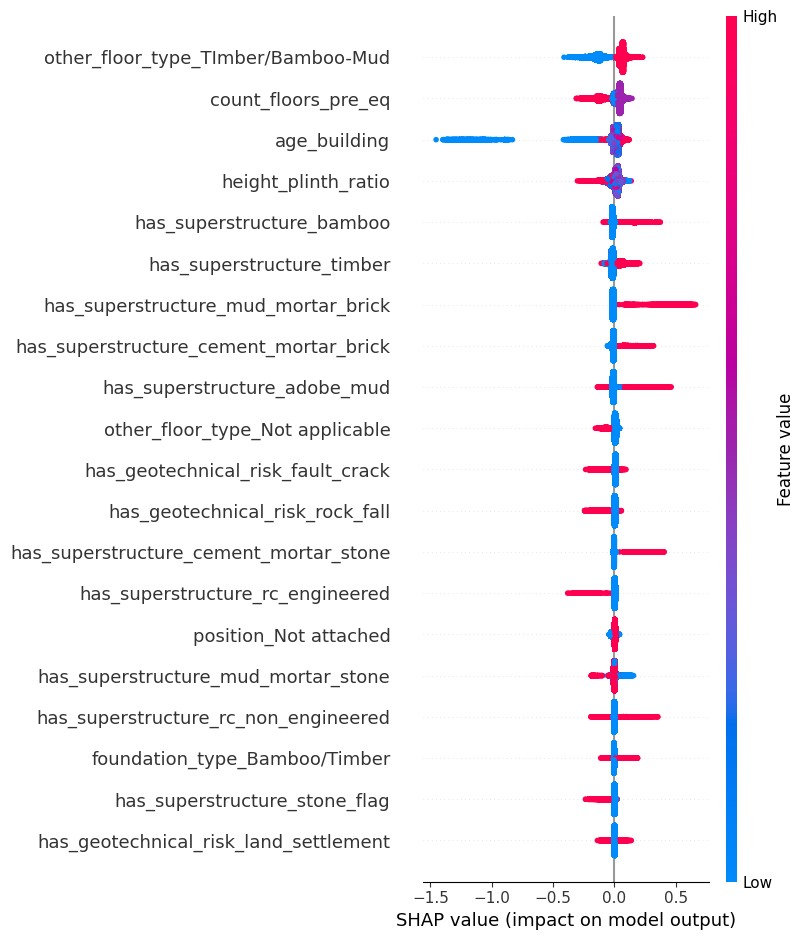

In [133]:
shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=keys)

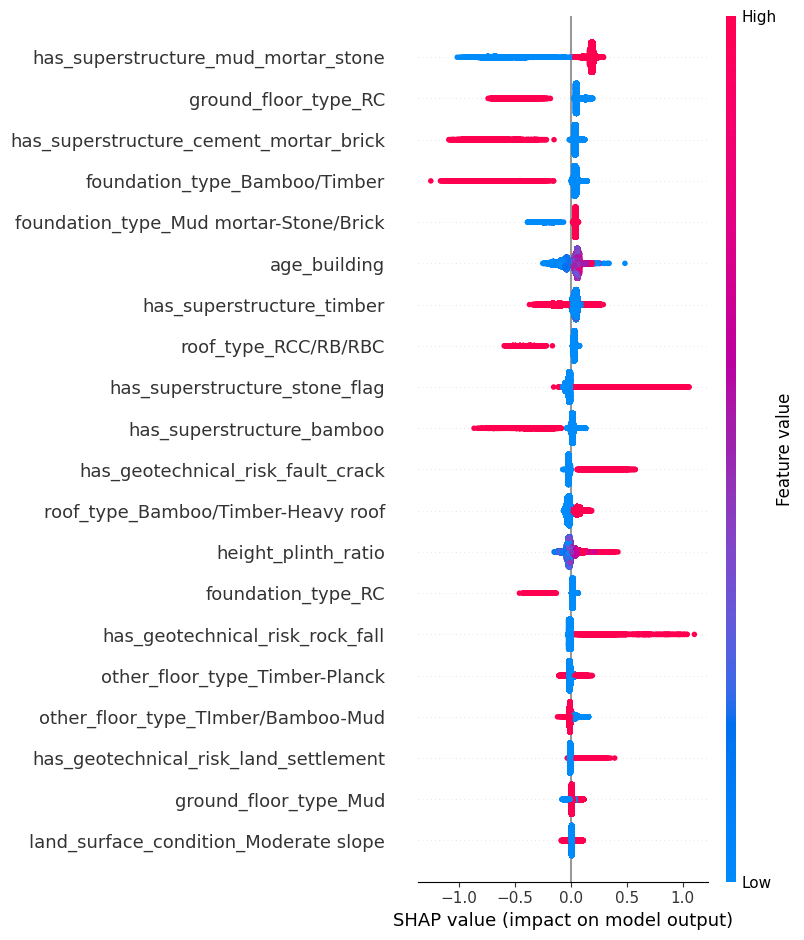

In [ ]:
shap.summary_plot(shap_values[:, :, 2], X_test, feature_names=keys)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

regression_params = {
    'objective': 'regression',        # Changed to regression
    'metric': 'mae',                 # Changed to RMSE (root mean squared error)
    'learning_rate': 0.1,
    'max_depth': -1,                  # -1 means no limit
    'num_leaves': 31,                 # Maximum tree leaves for base learners
    'feature_fraction': 0.8,          # Randomly select a subset of features on each iteration
    'bagging_fraction': 0.8,          # Randomly select a subset of data without resampling
    'bagging_freq': 5,                # Perform bagging every 5 iterations
    'verbose': -1,                    # Suppress printing messages
    'device_type:': 'cuda',            # Use GPU for training
    'n_estimators': 1000,             # Number of boosting iterations
    'boosting_type': 'gbdt'           # Traditional Gradient Boosting Decision Tree
}

rounds = 1000
reg_model = train(X_train, y_train, X_val, y_val, regression_params, rounds)
print(
test_regression(reg_model, X_val, y_val),
test_regression(reg_model, X_test, y_test)
)

{'RMSE': np.float64(0.527402750576039), 'MAE': 0.467848319804432, 'R2': 0.2970434953724683} {'RMSE': np.float64(0.5268784719507869), 'MAE': 0.4678294497896698, 'R2': 0.3019922071378761}


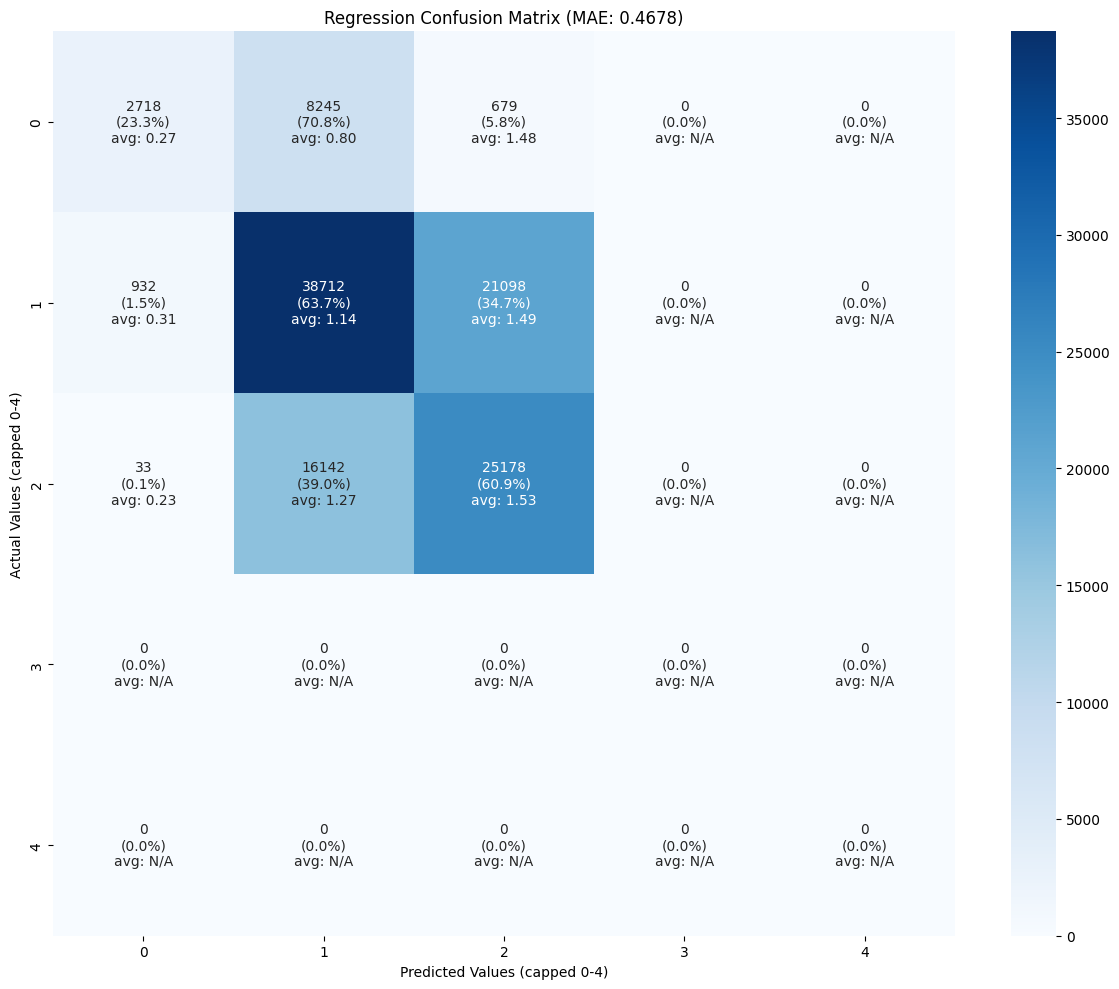

Original MAE (before capping): 0.4678
Overall accuracy (after capping and rounding): 58.56%

Average prediction by true class:
  True class 0: avg prediction = 0.71
  True class 1: avg prediction = 1.25
  True class 2: avg prediction = 1.43


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_absolute_error

# Get predictions
y_pred_test = reg_model.predict(X_test)

# Calculate MAE (on original predictions, before capping)
mae = mean_absolute_error(y_test, y_pred_test)

# Cap values between 0 and 4 for both actual and predicted values
y_test_capped = np.clip(y_test, 0, 2)
y_pred_capped = np.clip(y_pred_test, 0, 2)

# Convert regression values to integers using traditional rounding
y_test_int = np.floor(y_test_capped + 0.6).astype(int)
y_pred_int = np.floor(y_pred_capped + 0.6).astype(int)

# Get unique classes (all possible integer values, should be 0,1,2,3,4)
all_classes = np.array([0, 1, 2, 3, 4])  # Explicitly define to ensure all classes are included

# Create confusion matrix
cm = confusion_matrix(y_test_int, y_pred_int, labels=all_classes)

# Calculate percentages for each cell (accuracy within each true class)
row_sums = cm.sum(axis=1)[:, np.newaxis]
row_sums = np.where(row_sums == 0, 1, row_sums)  # Replace zeros with ones to avoid division by zero
cm_percent = cm.astype('float') / row_sums * 100

# Calculate average predicted values for each cell in the confusion matrix
avg_pred_values = np.zeros_like(cm, dtype=float)

for i in range(len(all_classes)):
    for j in range(len(all_classes)):
        # Find indices where true class is i and predicted class (after rounding) is j
        mask = (y_test_int == all_classes[i]) & (y_pred_int == all_classes[j])
        if np.sum(mask) > 0:
            # Calculate average of the original regression predictions for these instances
            avg_pred_values[i, j] = np.mean(y_pred_test[mask])
        else:
            avg_pred_values[i, j] = np.nan

# Create a formatted annotation matrix combining counts, percentages, and average predicted values
annot = np.empty_like(cm, dtype=object)
for i in range(len(cm)):
    for j in range(len(cm[i])):
        if not np.isnan(avg_pred_values[i, j]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)\navg: {avg_pred_values[i, j]:.2f}"
        else:
            annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)\navg: N/A"

# Plot with combined annotations
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
            xticklabels=all_classes, yticklabels=all_classes)
plt.title(f'Regression Confusion Matrix (MAE: {mae:.4f})')
plt.xlabel('Predicted Values (capped 0-4)')
plt.ylabel('Actual Values (capped 0-4)')
plt.tight_layout()
plt.show()

# Calculate overall accuracy from confusion matrix
overall_accuracy = np.sum(np.diag(cm)) / np.sum(cm) * 100
print(f"Original MAE (before capping): {mae:.4f}")
print(f"Overall accuracy (after capping and rounding): {overall_accuracy:.2f}%")

# Display additional statistics about predictions by true class
print("\nAverage prediction by true class:")
for cls in all_classes:
    mask = y_test_int == cls
    if np.sum(mask) > 0:
        avg_pred = np.mean(y_pred_test[mask])
        print(f"  True class {cls}: avg prediction = {avg_pred:.2f}")

In [ ]:
# Get the nuber counts in y test
y

array([1, 2, 1, ..., 2, 2, 2])